In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from scipy.special import logsumexp,erf

from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree_torch import Tree
from SLCVI_torch import SLCVI

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

np.random.seed(0)

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(torch.__version__)

2.2.2


In [219]:
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/DS1/DS1.pickle'

In [220]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [221]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [222]:
n_species = 3
genome_size = 100
genomes = ['']*n_species
ps = [[0.9,0.01,0,0,0.09],
      [0.9,0.1,0,0,0.0],
      [0.9,0.1,0,0,0.0]]
for _ in range(genome_size):
    for s in range(n_species):
        genomes[s] += np.random.choice(['A','T','G','C','-'],p=ps[s])
        
#genomes = [["A"],["T"],["C"]]

In [223]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = torch.log(tree_log_probs)

# Set initial $\theta$ randomly

In [224]:
theta = torch.zeros((2,n_species,n_species))

#theta[0] = torch.normal(mean=0.0,std=1.0,size = (n_species,n_species)) + np.log(pop_size)
#theta[0] = theta[0]*torch.tril(torch.ones((n_species,n_species)),diagonal=-1)
#theta[1] = 0.01*torch.normal(mean=0.0,std=1.0,size = (n_species,n_species))
#theta[1] = theta[1]*torch.tril(torch.ones((n_species,n_species)),diagonal=-1)

print(theta)

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])


In [225]:
Z = torch.normal(torch.ones_like(theta[0]))
log_times = torch.exp(theta[1])*Z+theta[0]
log_times = log_times + torch.triu(torch.ones_like(theta[0])*np.inf)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

print(tree.log_like)
print(tree.log_prior)
print(tree.log_q)

tensor(-394.7621)
tensor(-4.6240)
tensor(-6.6657)


# Do Variational Inference

In [226]:
genomes

['AAAAAAAAA-AAAAAAAAAAAAAA-AAAAAAAAAAAAAAAAAAAAAAAA-AAAAAAAAA-AAAAAAAAAA-AAAA--AAAAAAAAA-AAA---AAAAAAA',
 'AAAATAAAAAAAAAAAATAAAAATAAAAAAAAAATATAAAAAAAAAAAAAAAAAAAAAAAATAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAT',
 'AATAAATAAAAATAAAAAAAAAAAAAAAATAAAAAAAAAATAAAAAAAATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAATTAATAAATAAAAAAAT']

iteration:  0
runtime: 0 mins
grad_norm estimate:  43.08471592985257
ELBO estimate:  -328.12733801749886

iteration:  10
runtime: 0 mins
grad_norm estimate:  37.35326103022067
ELBO estimate:  -318.6172590523645

iteration:  20
runtime: 0 mins
grad_norm estimate:  23.916494067139453
ELBO estimate:  -307.70619214837035

iteration:  30
runtime: 0 mins
grad_norm estimate:  30.738390901176373
ELBO estimate:  -310.50122208282886

iteration:  40
runtime: 0 mins
grad_norm estimate:  24.346620416259324
ELBO estimate:  -311.42862664284195

iteration:  50
runtime: 0 mins
grad_norm estimate:  27.634547641242705
ELBO estimate:  -306.414945221772

iteration:  60
runtime: 0 mins
grad_norm estimate:  30.550002760471845
ELBO estimate:  -302.36640813300903

iteration:  70
runtime: 0 mins
grad_norm estimate:  24.39880836261106
ELBO estimate:  -284.76449273760755

iteration:  80
runtime: 0 mins
grad_norm estimate:  20.370286270717635
ELBO estimate:  -288.7910453589905

iteration:  90
runtime: 0 mins
grad_

iteration:  760
runtime: 0 mins
grad_norm estimate:  5.358895084474654
ELBO estimate:  -239.53813422011234

iteration:  770
runtime: 0 mins
grad_norm estimate:  3.3792697029931085
ELBO estimate:  -239.4825595235988

iteration:  780
runtime: 0 mins
grad_norm estimate:  0.7696038958509493
ELBO estimate:  -239.45554117108023

iteration:  790
runtime: 0 mins
grad_norm estimate:  1.789121015911388
ELBO estimate:  -239.46987423868998

iteration:  800
runtime: 0 mins
grad_norm estimate:  2.781032713042892
ELBO estimate:  -239.55689300799412

iteration:  810
runtime: 0 mins
grad_norm estimate:  1.9031042387199844
ELBO estimate:  -239.43802120531507

iteration:  820
runtime: 0 mins
grad_norm estimate:  2.323421229419332
ELBO estimate:  -239.39390227201616

iteration:  830
runtime: 0 mins
grad_norm estimate:  2.350015636529168
ELBO estimate:  -239.2943570789952

iteration:  840
runtime: 0 mins
grad_norm estimate:  1.6323383670240597
ELBO estimate:  -239.52089162733276

iteration:  850
runtime: 0

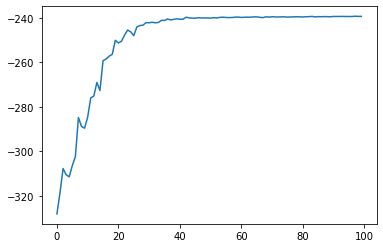

In [227]:
optim_reparam = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reparam.learn(batch_size=10,
                      iters=1000,
                      alpha=0.01,
                      method="reparam",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reparam.theta)
plt.plot(optim_reparam.ELBO_ests)

iteration:  0
runtime: 0 mins
grad_norm estimate:  38.43973875516439
ELBO estimate:  -329.8701941067863

iteration:  10
runtime: 0 mins
grad_norm estimate:  36.28950830847884
ELBO estimate:  -320.15278107614694

iteration:  20
runtime: 0 mins
grad_norm estimate:  28.623932025158098
ELBO estimate:  -314.09697617887804

iteration:  30
runtime: 0 mins
grad_norm estimate:  26.125374843586833
ELBO estimate:  -305.11672448248976

iteration:  40
runtime: 0 mins
grad_norm estimate:  77.58405795857415
ELBO estimate:  -307.85865259639104

iteration:  50
runtime: 0 mins
grad_norm estimate:  35.33743184042264
ELBO estimate:  -304.2297379294963

iteration:  60
runtime: 0 mins
grad_norm estimate:  49.814569462677106
ELBO estimate:  -291.8640108852678

iteration:  70
runtime: 0 mins
grad_norm estimate:  83.84735010970131
ELBO estimate:  -295.8643773878975

iteration:  80
runtime: 0 mins
grad_norm estimate:  24.47015868846637
ELBO estimate:  -293.18402121382474

iteration:  90
runtime: 0 mins
grad_nor

iteration:  760
runtime: 0 mins
grad_norm estimate:  2.4195362795686406
ELBO estimate:  -239.40695788901002

iteration:  770
runtime: 0 mins
grad_norm estimate:  0.2464052955281585
ELBO estimate:  -239.56402348707945

iteration:  780
runtime: 0 mins
grad_norm estimate:  0.6428614552937347
ELBO estimate:  -239.40776722697618

iteration:  790
runtime: 0 mins
grad_norm estimate:  0.6045700315592651
ELBO estimate:  -239.39758295941573

iteration:  800
runtime: 0 mins
grad_norm estimate:  2.5321702512761957
ELBO estimate:  -239.35394137955583

iteration:  810
runtime: 0 mins
grad_norm estimate:  0.9396918088291338
ELBO estimate:  -239.39929235567195

iteration:  820
runtime: 0 mins
grad_norm estimate:  0.21583798352892503
ELBO estimate:  -239.49961453900494

iteration:  830
runtime: 0 mins
grad_norm estimate:  0.25110384728168
ELBO estimate:  -239.39834999376825

iteration:  840
runtime: 0 mins
grad_norm estimate:  0.6008157039045391
ELBO estimate:  -239.38084171042954

iteration:  850
runt

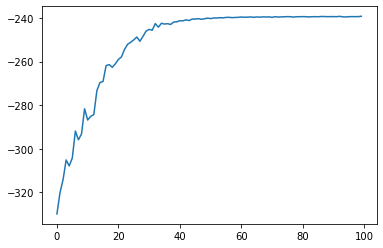

In [231]:
optim_reinforce = SLCVI(tree_log_probs,deepcopy(theta),pop_size)

optim_reinforce.learn(batch_size=10,
                      iters=1000,
                      alpha=0.01,
                      method="reinforce",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
plt.plot(optim_reinforce.ELBO_ests)

iteration:  0
runtime: 0 mins
grad_norm estimate:  1.7526383251911977
ELBO estimate:  -321.0370410433597

iteration:  10
runtime: 0 mins
grad_norm estimate:  6.685020230127706
ELBO estimate:  -287.4342859435648

iteration:  20
runtime: 0 mins
grad_norm estimate:  0.8488974387866551
ELBO estimate:  -285.7503932963884

iteration:  30
runtime: 0 mins
grad_norm estimate:  0.6311391616026374
ELBO estimate:  -269.38852197401815

iteration:  40
runtime: 0 mins
grad_norm estimate:  7.538401506414166
ELBO estimate:  -271.51743465020485

iteration:  50
runtime: 0 mins
grad_norm estimate:  2.023035767967789
ELBO estimate:  -261.03444219385176

iteration:  60
runtime: 0 mins
grad_norm estimate:  0.41039204360833387
ELBO estimate:  -259.8052717618255

iteration:  70
runtime: 0 mins
grad_norm estimate:  0.2755520859250094
ELBO estimate:  -257.57372991794506

iteration:  80
runtime: 0 mins
grad_norm estimate:  0.9436884333568384
ELBO estimate:  -252.13866529010187

iteration:  90
runtime: 0 mins
grad

iteration:  760
runtime: 0 mins
grad_norm estimate:  0.5131425017301814
ELBO estimate:  -239.94985161608219

iteration:  770
runtime: 0 mins
grad_norm estimate:  0.3632286080208463
ELBO estimate:  -240.46104041466236

iteration:  780
runtime: 0 mins
grad_norm estimate:  1.1595285412951113
ELBO estimate:  -239.68800278859237

iteration:  790
runtime: 0 mins
grad_norm estimate:  0.6896401934247732
ELBO estimate:  -239.95697392887928

iteration:  800
runtime: 0 mins
grad_norm estimate:  0.6734579794248824
ELBO estimate:  -240.13317571304168

iteration:  810
runtime: 0 mins
grad_norm estimate:  0.2316057458989058
ELBO estimate:  -239.8617723236762

iteration:  820
runtime: 0 mins
grad_norm estimate:  0.6927663946060414
ELBO estimate:  -239.93371501106932

iteration:  830
runtime: 0 mins
grad_norm estimate:  0.7004899568078069
ELBO estimate:  -240.07272309910968

iteration:  840
runtime: 0 mins
grad_norm estimate:  0.45620714801679096
ELBO estimate:  -240.36495565434984

iteration:  850
run

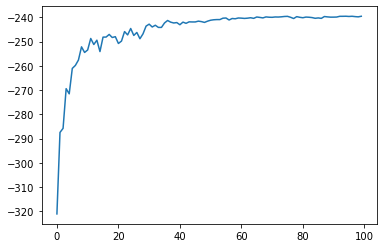

In [232]:
np.random.seed(0)
optim_VIMCO = SLCVI(tree_log_probs,deepcopy(theta),pop_size)

optim_VIMCO.learn(batch_size=10,
                  iters=1000,
                  alpha=0.1,
                  method="VIMCO",
                  record_every=10,
                  pop_size=pop_size)
print("final theta:",optim_VIMCO.theta)
plt.plot(optim_VIMCO.ELBO_ests)

In [233]:
print(optim_reparam.ELBO_ests[-1])
print(optim_reinforce.ELBO_ests[-1])
print(optim_VIMCO.ELBO_ests[-1])

tensor(-239.2841)
tensor(-239.1866)
tensor(-239.5301)


# Print out a random tree

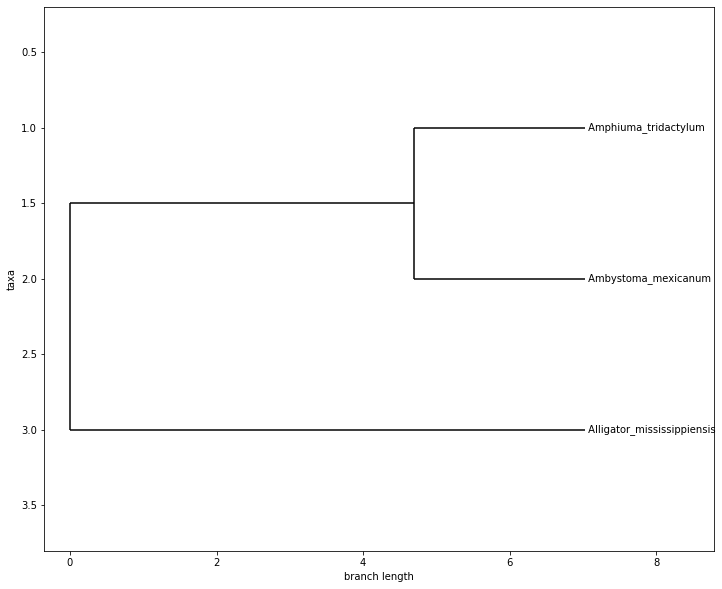

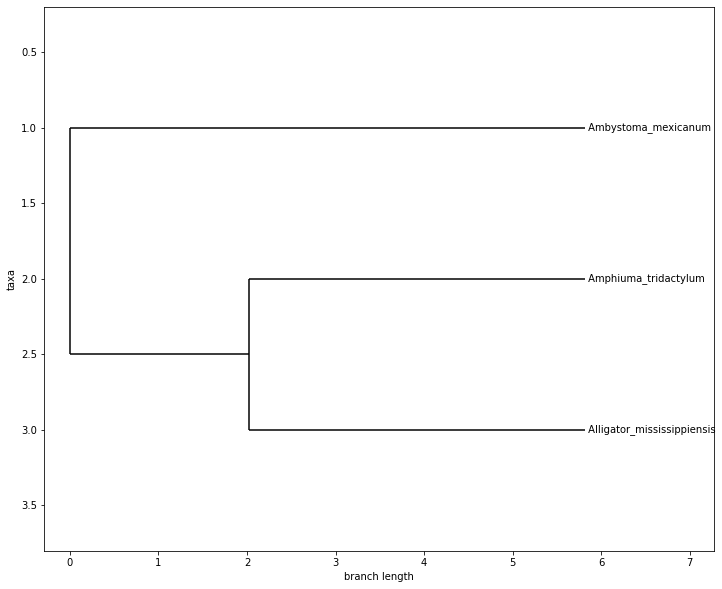

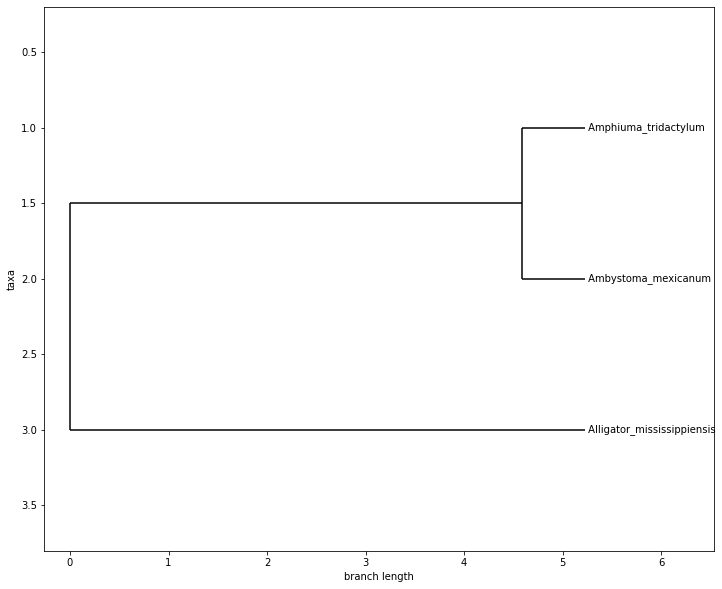

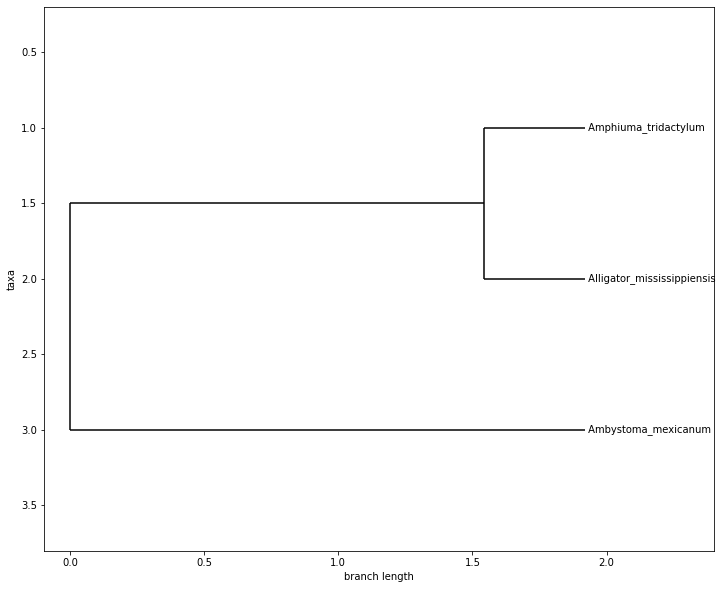

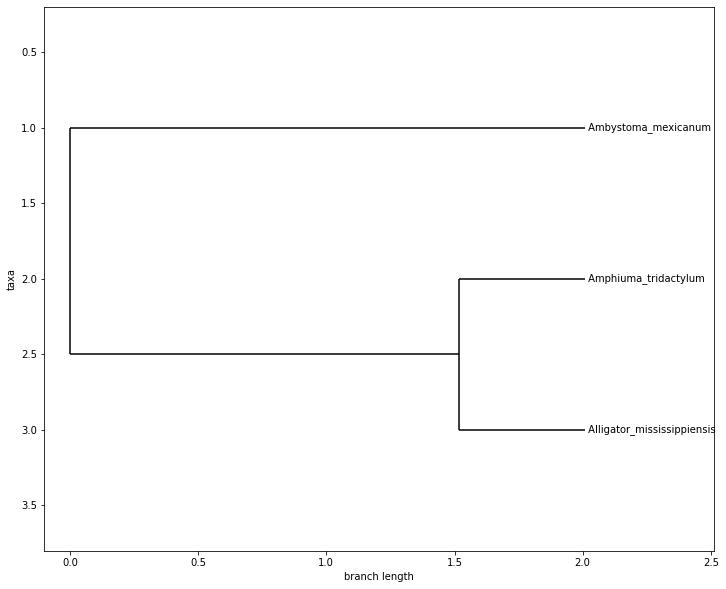

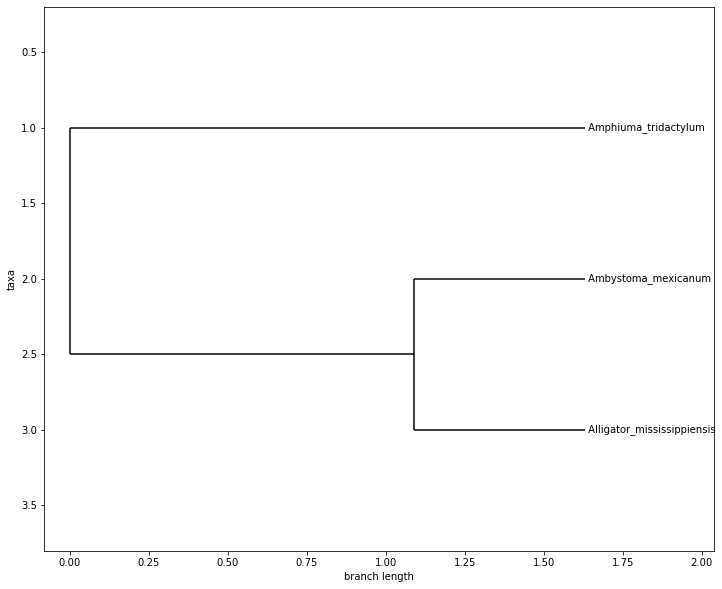

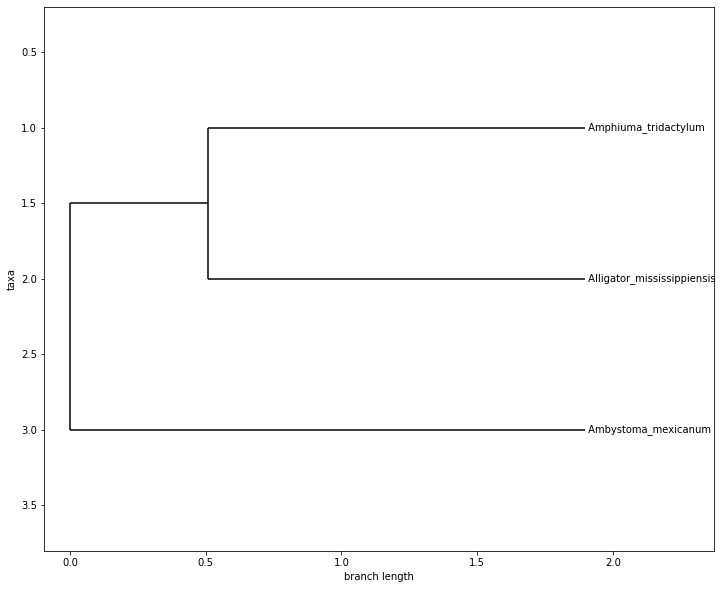

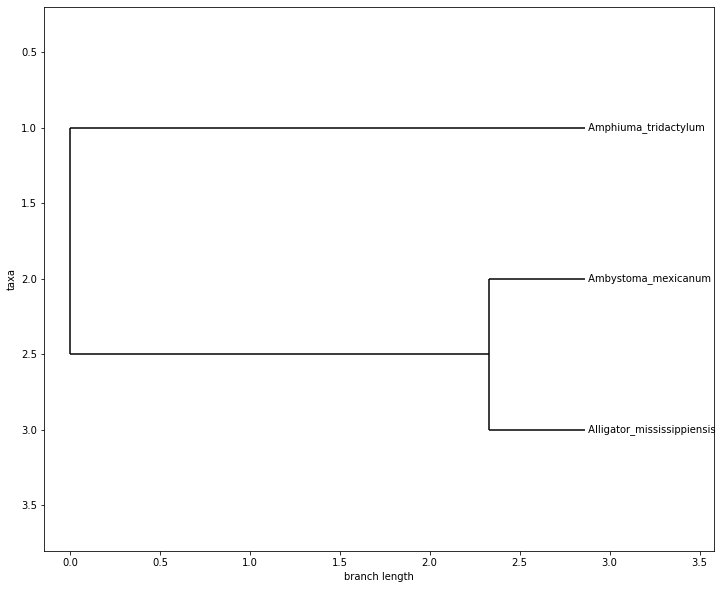

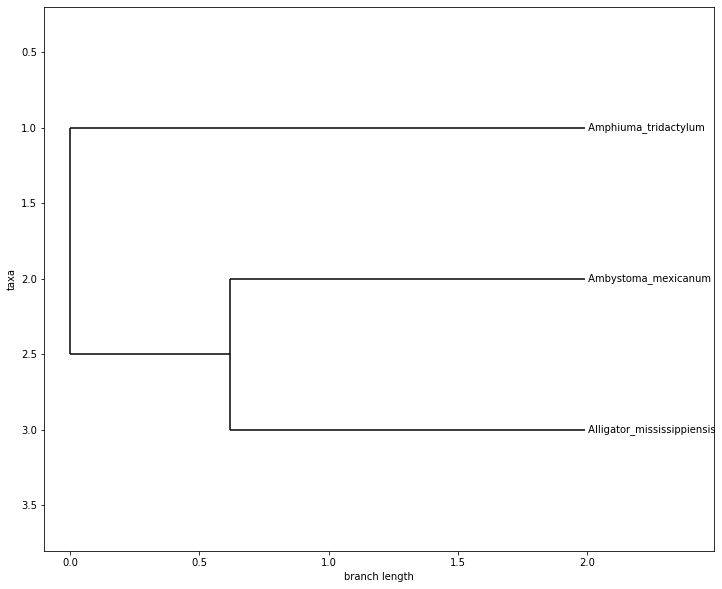

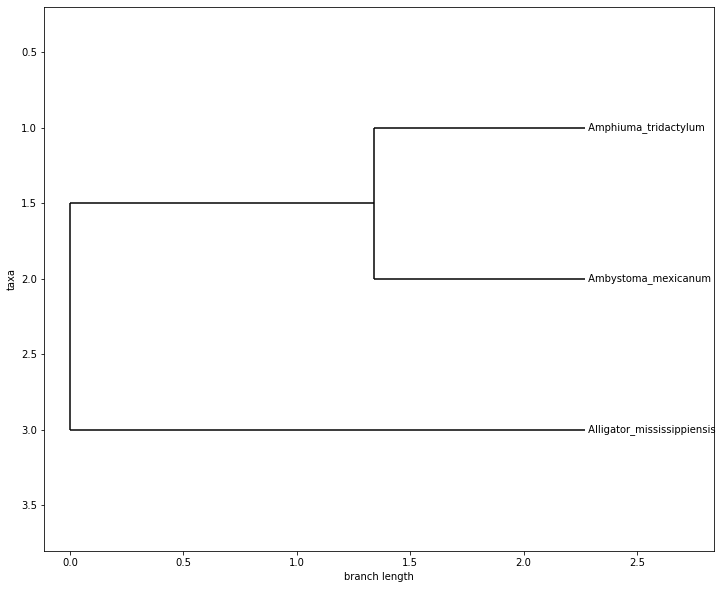

In [234]:
def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

    
for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)
    fig.show()

# Estimate the marginal likelihood

In [235]:
optim = optim_reinforce
theta = optim.theta

In [236]:
tree = Tree(optim.theta,log_times,
            deepcopy(tree_log_probs),
            pop_size=pop_size)

In [237]:
theta

Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000],
         [-2.7105,  0.0000,  0.0000],
         [-2.4891, -1.9774,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [-0.8950,  0.0000,  0.0000],
         [-0.9643, -1.0199,  0.0000]]], requires_grad=True)

In [238]:
n_exp = 100
n_samples = 100

priors = np.zeros(n_exp)
LL = np.zeros(n_exp)
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp) 

for i in range(n_exp):

    if i % 10 == 0:
        print(i)
    
    MLL = np.zeros(n_samples)
    ELBO = np.zeros(n_samples)
    
    Zs = torch.normal(mean=0.0,std=1.0,size=(n_samples,n_species,n_species))

    for j,Z in enumerate(Zs):
        log_times = torch.exp(theta[1])*Z+theta[0]
        log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
        tree = Tree(optim.theta,log_times,
                    deepcopy(tree_log_probs),
                    pop_size=pop_size)
        
        MLL[j] = tree.log_p - tree.log_q
        ELBO[j] = tree.log_p - tree.log_q
    
    priors[i] = tree.log_prior
    LL[i] = tree.log_like
    MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
    ELBO_all[i] = np.mean(ELBO)

0
10
20
30
40
50
60
70
80
90


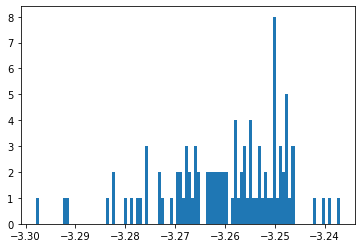

In [239]:
plt.hist(priors,bins = 100)
plt.show()

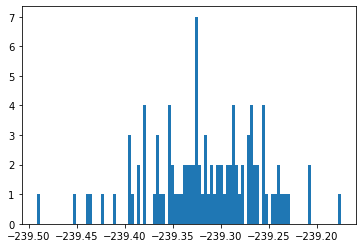

In [240]:
plt.hist(ELBO_all,bins = 100)
plt.show()

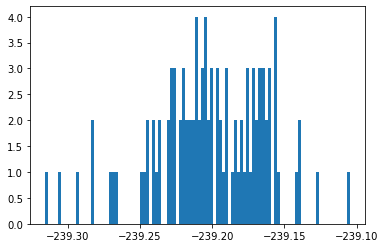

In [241]:
plt.hist(MLL_all,bins = 100)
plt.show()

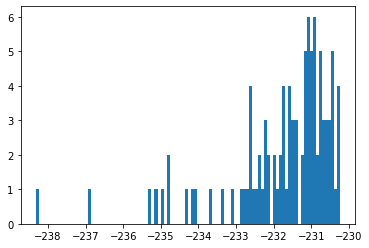

In [242]:
plt.hist(LL,bins = 100)
plt.show()

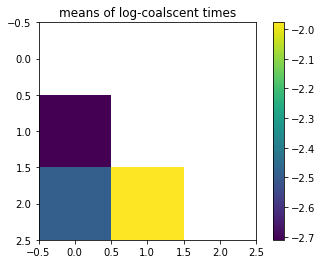

In [243]:
m = deepcopy(theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

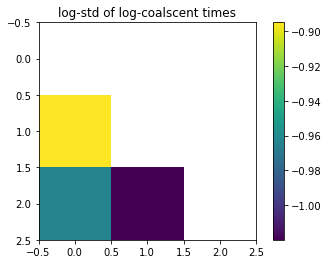

In [244]:
log_sig = deepcopy(theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

# Plot the likelihood surface for 3-taxa trees

In [245]:
def plot_q(theta,res):
    
    # select t lims from sampling 1000 trees
    min_time = np.min((-5*np.exp(theta[1].detach().numpy())+theta[0].detach().numpy())[np.tril(np.full((n_species), True),k=-1)])
    max_time = np.max(( 3*np.exp(theta[1].detach().numpy())+theta[0].detach().numpy())[np.tril(np.full((n_species), True),k=-1)])
    tlims = [min_time,max_time]

    #print(theta)
    log_p = np.zeros((3,res,res))
    log_q = np.zeros((3,res,res))
    ELBO = np.zeros((3,res,res))

    orders = [[0,1,2],[0,2,1],[1,2,0]]
    tau_labels = ['(({A},{B}),({A,B},{C}))',
                  '(({A},{C}),({A,C},{B}))',
                  '(({B},{C}),({A},{B,C})']

    for k,inds in enumerate(orders):

        time1s = np.linspace(tlims[0],tlims[1],res)
        time2s = np.linspace(tlims[0],tlims[1],res)

        for i,time1 in enumerate(time1s):
            for j,time2 in enumerate(time2s):

                if time1 > time2:
                    log_p[k,j,i] = -np.inf
                    log_q[k,j,i] = -np.inf

                else:
                    times = np.inf*torch.ones((3,3))

                    inds1 = [inds[x] for x in [0,1]]
                    inds2 = [inds[x] for x in [0,2]]
                    inds3 = [inds[x] for x in [1,2]]

                    times[max(inds1),min(inds1)] = time1
                    times[max(inds2),min(inds2)] = time2
                    times[max(inds3),min(inds3)] = time2+1

                    tree = Tree(theta,times,tree_log_probs,
                                pop_size=pop_size)

                    log_p[k,j,i] = tree.log_p
                    log_q[k,j,i] = tree.log_q
                    ELBO[k,j,i] = torch.exp(tree.log_q)*(tree.log_p - tree.log_q)
    log_p = log_p-logsumexp(log_p[~np.isnan(log_p)])+logsumexp(log_q[~np.isnan(log_q)])
    vmax = np.nanmax([log_p,log_q])

    i = 0
    plt.subplots(figsize = (20,12))
    for k in range(3):

        i += 1
        plt.subplot(3,3,i)

        plt.imshow(log_p[k], interpolation='nearest', origin='lower',
                   extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmax-6,vmax=vmax)
        plt.xlabel(r'$\log(t_1)$',fontsize = 16)
        plt.ylabel(r'$\log(t_2)$',fontsize = 16)
        plt.title(r'log(p), $\tau$ = %s' % tau_labels[k],fontsize = 16)
        plt.colorbar()

        plt.subplot(3,3,i+3)

        plt.imshow(log_q[k], interpolation='nearest', origin='lower',
                   extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmax-6,vmax=vmax)
        plt.xlabel(r'$\log(t_1)$',fontsize = 16)
        plt.ylabel(r'$\log(t_2)$',fontsize = 16)
        plt.title(r'log(q), $\tau$ = %s' % tau_labels[k],fontsize = 16)
        plt.colorbar()

    plt.show()
    return

REINFORCE:


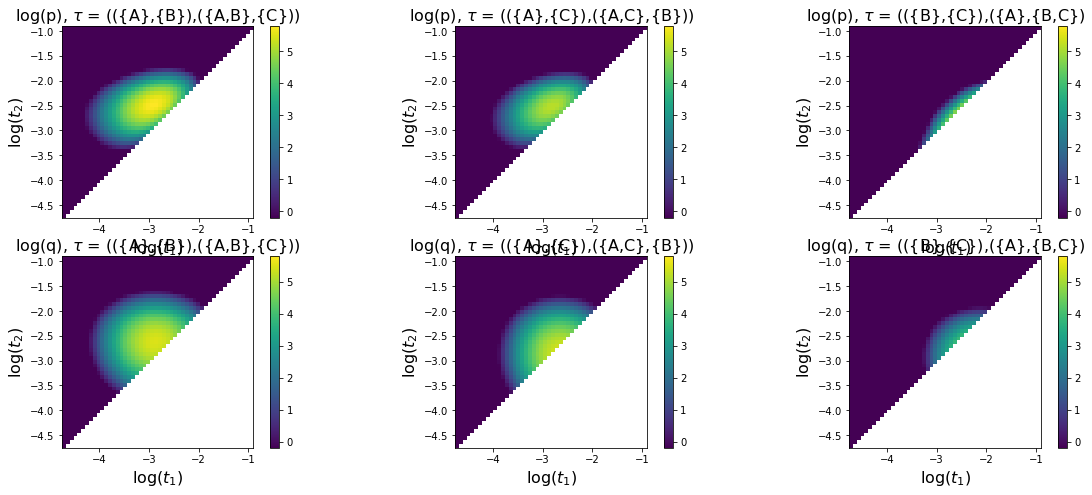

VIMCO:


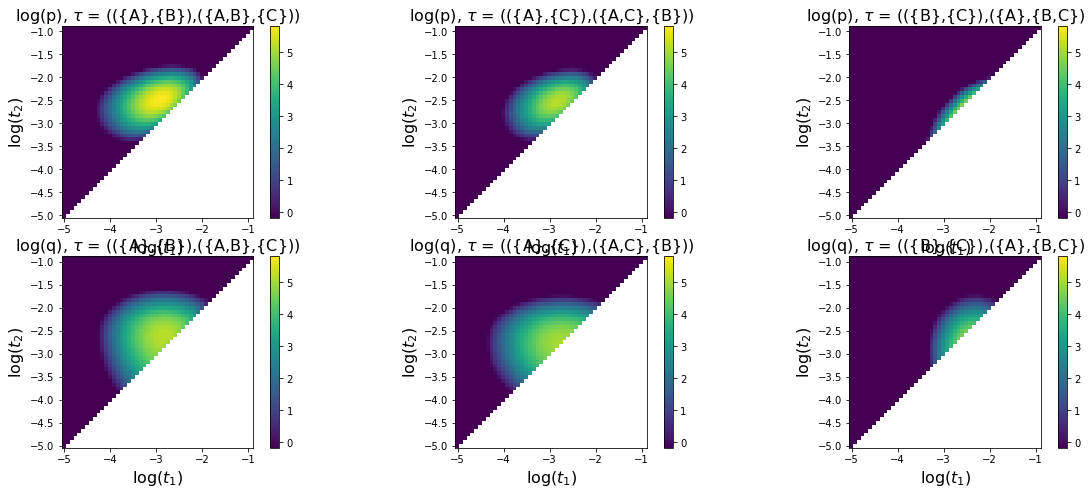

Reparam:


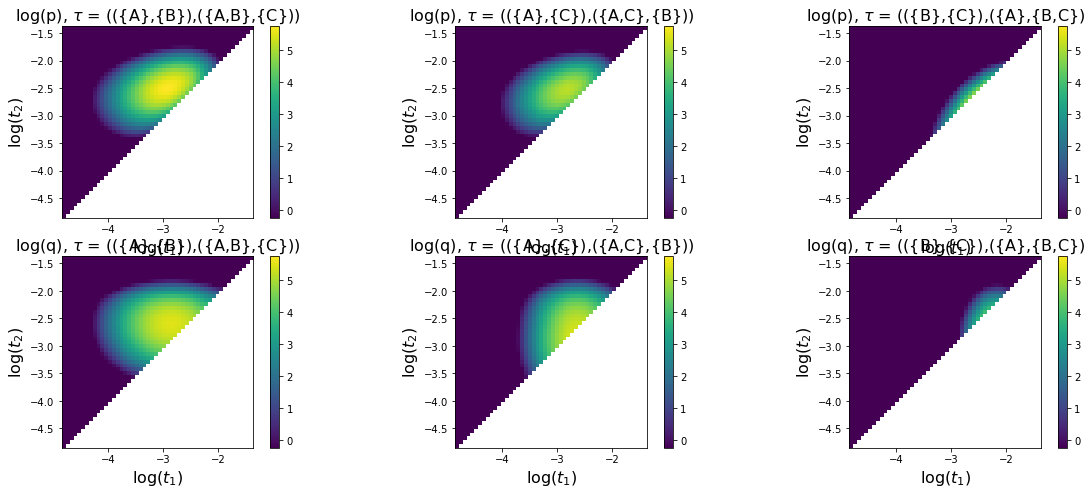

In [246]:
print("REINFORCE:")
plot_q(optim_reinforce.theta,res=50)
print("VIMCO:")
plot_q(optim_VIMCO.theta,res=50)
print("Reparam:")
plot_q(optim_reparam.theta,res=50)

# Visualize the boundary

In [ ]:
theta = optim.theta
res = 500

# select t lims from sampling 1000 trees
Z1 = 0
min_time = np.min((-5*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
max_time = np.max(( 3*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
tlims = [min_time,max_time]

#print(theta)
log_p = np.zeros((3,res))
log_q = np.zeros((3,res))
ELBO = np.zeros((3,res))

eps = 0.00001

orders = [[0,1,2],[0,2,1],[1,2,0]]
tau_labels = ['(({A},{B}),({A,B},{C}))',
              '(({A},{C}),({A,C},{B}))',
              '(({B},{C}),({A},{B,C})']

for k,inds in enumerate(orders):
    
    time1s = np.linspace(tlims[0],tlims[1],res)
    
    for i,time1 in enumerate(time1s):
        
        time2 = time1 + eps
                
        times = np.inf*np.ones((3,3))

        inds1 = [inds[x] for x in [0,1]]
        inds2 = [inds[x] for x in [0,2]]
        inds3 = [inds[x] for x in [1,2]]

        times[max(inds1),min(inds1)] = time1
        times[max(inds2),min(inds2)] = time2
        times[max(inds3),min(inds3)] = time2+1

        tree = Tree(theta,times,tree_log_probs,
                    pop_size=pop_size)

        log_p[k,i] = tree.log_p
        log_q[k,i] = tree.log_q
        ELBO[k,i] = np.exp(tree.log_q)*(tree.log_p - tree.log_q)

In [ ]:
np.max(np.exp(log_q.T))

In [ ]:
plt.plot(time1s,np.exp(log_q.T)*(log_p.T-log_q.T))
plt.show()

In [ ]:
plt.plot(time1s,log_q.T,'-.')
plt.show()

In [ ]:
theta = optim.theta
res = 200

# select t lims from sampling 1000 trees
Z1 = -3
Z2s = np.linspace(-5,5,res)
Z3s = np.linspace(-5,5,res)
tlims = [-5,5]

#print(theta)
log_p = np.zeros((res,res))
log_q = np.zeros((res,res))
ELBO = np.zeros((res,res))
    
for i,Z2 in enumerate(Z2s):
    for j,Z3 in enumerate(Z3s):

        Z = np.array([[np.inf,np.inf,np.inf],
                      [Z2    ,np.inf,np.inf],
                      [Z3    ,Z1   ,np.inf]])

        log_times = np.exp(theta[1])*Z+theta[0]

        tree = Tree(theta,log_times,tree_log_probs,
                    pop_size=pop_size)

        log_p[j,i] = tree.log_p
        log_q[j,i] = tree.log_q
        ELBO[j,i] = (tree.log_p-tree.log_q)


In [ ]:
#log_p = log_p-logsumexp(log_p[~np.isnan(log_p)])+logsumexp(log_q[~np.isnan(log_q)])
vmaxp = np.nanmax([log_p])
vmaxq = np.nanmax([log_q])
plt.subplots(figsize = (20,12))
    
plt.subplot(1,3,1)

plt.imshow(log_p, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmaxp-6,vmax=vmaxp)
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'log(p), $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()

plt.subplot(1,3,2)

plt.imshow(log_q, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmaxq-6,vmax=vmaxq)
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'log(q), $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()
    
plt.subplot(1,3,3)

plt.imshow(ELBO, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]])
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'ELBO, $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()
    
plt.show()

In [ ]:
theta

# Evaluate gradient of the ELBO

In [ ]:
genomes

In [ ]:
optim.theta

In [ ]:
np.exp(-1.6)

In [ ]:
# select t lims from plus or minus three standard deviations
min_time = np.min((-5*np.exp(optim.theta[1])+optim.theta[0])[np.tril(np.full((n_species), True),k=-1)])
max_time = np.max(( 3*np.exp(optim.theta[1])+optim.theta[0])[np.tril(np.full((n_species), True),k=-1)])
tlims = [min_time,max_time]

def ELBO_no_reparam(theta,res_no_reparam):

    ELBO = 0
    orders = [[0,1,2],[0,2,1],[1,2,0]]

    for k,inds in enumerate(orders):

        time1s = np.linspace(tlims[0],tlims[1],res_no_reparam)
        time2s = np.linspace(tlims[0],tlims[1],res_no_reparam)

        for i,time1 in enumerate(time1s):
            for j,time2 in enumerate(time2s):

                if time1 < time2:
                    
                    times = np.inf*np.ones((3,3))

                    inds1 = [inds[x] for x in [0,1]]
                    inds2 = [inds[x] for x in [0,2]]
                    inds3 = [inds[x] for x in [1,2]]

                    times[max(inds1),min(inds1)] = time1
                    times[max(inds2),min(inds2)] = time2
                    times[max(inds3),min(inds3)] = time2+1
                    
                    tree = Tree(theta,times,tree_log_probs,
                                pop_size=pop_size)

                    ELBO_hat = np.exp(tree.log_q)*(tree.log_p - tree.log_q)
                    
                    if not np.isnan(ELBO_hat):
                        
                        if i == 0:
                            length = 0
                        else:
                            length = np.exp(time1s[i]) - np.exp(time1s[i-1])
                            
                        if j == 0:
                            width = 0
                        else:
                            width = np.exp(time2s[j]) - np.exp(time2s[j-1])
                        
                        ELBO_hat = ELBO_hat*length*width
                        ELBO = ELBO + ELBO_hat
                    
    return ELBO

In [ ]:
ELBO_no_reparam(optim.theta,500)

In [ ]:
ELBO_no_reparam(optim.theta,300)

In [ ]:
ELBO_no_reparam(optim.theta,200)

In [ ]:
ELBO_no_reparam(optim.theta,100)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,100))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,200))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,300))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,500))(optim.theta)

# Reparameterize and see if the LOTUS applies

In [ ]:
res_reparam = 50

min_Z = -3
max_Z = 3

def ELBO_reparam(theta):
    
    ELBO = 0
    
    Z1s = np.linspace(min_Z,max_Z,res_reparam)
    Z2s = np.linspace(min_Z,max_Z,res_reparam)
    Z3s = np.linspace(min_Z,max_Z,res_reparam)
    
    for i,Z1 in enumerate(Z1s):
        for j,Z2 in enumerate(Z2s):
            for k,Z3 in enumerate(Z3s):
        
                Z = np.array([[np.inf,np.inf,np.inf],
                              [Z1    ,np.inf,np.inf],
                              [Z2    ,Z3    ,np.inf]])

                log_times = np.exp(theta[1])*Z+theta[0]

                tree = Tree(theta,log_times,tree_log_probs,
                            pop_size=pop_size)

                density = np.product(norm.pdf([Z1,Z2,Z3]))*((max_Z-min_Z)/res_reparam)**3

                ELBO_hat = density*(tree.log_p - tree.log_q)
        
                if not np.isnan(ELBO_hat):
                    ELBO = ELBO + ELBO_hat
                    
    return ELBO

In [ ]:
ELBO_reparam(optim.theta)

In [ ]:
grad(ELBO_reparam)(optim.theta)

# See if we can replace integration with sampling

In [ ]:
n_samples = 10000

# sample trees
Z1s = np.random.normal(size=n_samples)
Z2s = np.random.normal(size=n_samples)
Z3s = np.random.normal(size=n_samples)

def ELBO_reparam_sample(theta):
    
    ELBO = 0
    
    for Z1,Z2,Z3 in zip(Z1s,Z2s,Z3s):
        
        Z = np.array([[np.inf,np.inf,np.inf],
                      [Z1    ,np.inf,np.inf],
                      [Z2    ,Z3    ,np.inf]])

        log_times = np.exp(theta[1])*Z+theta[0]

        tree = Tree(theta,log_times,tree_log_probs,
                    pop_size=pop_size)

        density = 1/n_samples

        ELBO_hat = density*(tree.log_p - tree.log_q)

        if not np.isnan(ELBO_hat):
            ELBO = ELBO + ELBO_hat
                    
    return ELBO

print(ELBO_reparam_sample(optim.theta))
print(grad(ELBO_reparam_sample)(optim.theta))

# See if the sum of the gradients is the gradient of the sum

In [ ]:
res_reparam = 25

min_Z = -3
max_Z = 3

grad_ELBO_reparam = np.zeros_like(optim.theta)

Z1s = np.linspace(min_Z,max_Z,res_reparam)
Z2s = np.linspace(min_Z,max_Z,res_reparam)
Z3s = np.linspace(min_Z,max_Z,res_reparam)

for i,Z1 in enumerate(Z1s):
    for j,Z2 in enumerate(Z2s):
        for k,Z3 in enumerate(Z3s):

            Z = np.array([[np.inf,np.inf,np.inf],
                          [Z1    ,np.inf,np.inf],
                          [Z2    ,Z3    ,np.inf]])
            
            def ELBO_reparam_local(theta0):
                log_times = np.exp(theta0[1])*Z+theta0[0]
                tree = Tree(theta0,log_times,tree_log_probs,
                            pop_size=pop_size)
                return tree.log_p - tree.log_q

            grad_ELBO_hat = grad(ELBO_reparam_local)(optim.theta)
            density = np.product(norm.pdf([Z1,Z2,Z3]))*((max_Z-min_Z)/res_reparam)**3

            grad_ELBO_hat = density*grad_ELBO_hat

            if not np.isnan(grad_ELBO_hat).all():
                grad_ELBO_reparam = grad_ELBO_reparam + grad_ELBO_hat

In [ ]:
print(grad_ELBO_reparam)

# Plot both ELBOs as theta[0,2,0] changes

In [ ]:
h = 0.5
np.linspace(optim.theta[0,2,0]-h,optim.theta[0,2,0]+h,2)

In [ ]:
h = 0.1
thetas = np.linspace(optim.theta[0,2,0]-h,optim.theta[0,2,0]+h,3)

grad_ELBOS_reparam = []
grad_ELBOS_no_reparam = []

ELBOS_reparam = []
ELBOS_no_reparam = []

for theta in thetas:
    print(theta)
    
    theta0 = deepcopy(optim.theta)
    theta0[0,2,0] = theta
    
    ELBOS_reparam.append(ELBO_reparam(theta0))
    print("ELBO reparam:",ELBOS_reparam[-1])
    
    ELBOS_no_reparam.append(ELBO_no_reparam(theta0,500))
    print("ELBO no reparam:",ELBOS_no_reparam[-1])
    
    #grad_ELBOS_reparam.append(grad(ELBO_reparam)(theta0))
    #print("grad ELBO reparam:",grad_ELBOS_reparam[-1])
    
    #grad_ELBOS_no_reparam.append(grad(ELBO_no_reparam)(theta0))
    #print("grad ELBO no reparam:",grad_ELBOS_no_reparam[-1])
    
    print("")

In [ ]:
plt.plot(thetas,ELBOS_reparam)
plt.show()
plt.plot(thetas,ELBOS_no_reparam)
plt.show()

plt.plot(thetas,[x[0,2,0] for x in grad_ELBOS_reparam])
plt.show()
plt.plot(thetas,[x[0,2,0] for x in grad_ELBOS_no_reparam])
plt.show()

In [ ]:
h = 0.5
thetas = np.linspace(optim.theta[0,1,0]-h,optim.theta[0,1,0]+h,5)

grad_ELBOS_reparam = []
grad_ELBOS_no_reparam = []

ELBOS_reparam = []
ELBOS_no_reparam = []

for theta in thetas:
    print(theta)
    
    theta0 = deepcopy(optim.theta)
    theta0[0,1,0] = theta
    
    ELBOS_reparam.append(ELBO_reparam(theta0))
    print("ELBO reparam:",ELBOS_reparam[-1])
    
    ELBOS_no_reparam.append(ELBO_no_reparam(theta0))
    print("ELBO no reparam:",ELBOS_no_reparam[-1])
    
    grad_ELBOS_reparam.append(grad(ELBO_reparam)(theta0))
    print("grad ELBO reparam:",grad_ELBOS_reparam[-1])
    
    grad_ELBOS_no_reparam.append(grad(ELBO_no_reparam)(theta0))
    print("grad ELBO no reparam:",grad_ELBOS_no_reparam[-1])
    
    print("")

In [ ]:
plt.plot(thetas,ELBOS_reparam)
plt.show()
plt.plot(thetas,ELBOS_no_reparam)
plt.show()

plt.plot(thetas,[x[0,1,0] for x in grad_ELBOS_reparam])
plt.show()
plt.plot(thetas,[x[0,1,0] for x in grad_ELBOS_no_reparam])
plt.show()

# Finally, see if we can move the sampling outside

In [ ]:
n_samples = 1000

# select t lims from sampling 1000 trees
min_Z = -3
max_Z = 3
    
grad_ELBO = np.zeros_like(optim.theta)

Z1s = np.random.normal(size=n_samples)
Z2s = np.random.normal(size=n_samples)
Z3s = np.random.normal(size=n_samples)

for Z1,Z2,Z3 in zip(Z1s,Z2s,Z3s):

    Z = np.array([[np.inf,np.inf,np.inf],
                  [Z1    ,np.inf,np.inf],
                  [Z2    ,Z3    ,np.inf]])

    def ELBO_reparam_sample_local(theta0):
        times = np.exp(theta0[1])*Z+theta0[0]
        tree = Tree(theta0,times,genomes,
                    pop_size=pop_size)
        return tree.log_p - tree.log_q

    grad_ELBO_hat = grad(ELBO_reparam_local)(optim.theta)
    density = 1/n_samples

    grad_ELBO_hat = density*grad_ELBO_hat

    if not np.isnan(grad_ELBO_hat).all():
        grad_ELBO = grad_ELBO + grad_ELBO_hat
                
print(grad_ELBO)

# See if we are actually sampling from Q when we do this

In [ ]:
plt.hist([x[1,1,0] for x in grad_thetas])

In [ ]:
theta

In [ ]:
times

In [ ]:
t1s = []
t2s = []

for _ in range(10000):
    
    # draw times
    Z = np.random.normal(np.ones_like(optim.theta[0]))
    times = np.exp(optim.theta[1])*Z+optim.theta[0]
    maxi = np.max(times)
    times = times + np.triu(np.ones_like(optim.theta[0])*maxi)
    
    # find t1 and t2
    t1 = np.min(times)
    t2 = np.min(times[times != t1])
    
    t1s.append(t1)
    t2s.append(t2)
    
    last_coal = {0,1,2}
    last_coal.remove(np.nonzero(times == t1)[0][0])
    last_coal.remove(np.nonzero(times == t1)[1][0])

In [ ]:
plt.hist(t2s,bins = 100)